In [1035]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  

# Data Transformation

### Reading and Clean the Dataset

In [1036]:
# Load dataset and convert 'Date' column to datetime format
df = pd.read_csv('../data/DATASET_final_untransformed_uncleaned.csv', sep=";")
df["Date"] = pd.to_datetime(df["Date"])

# Keep only the data from June 1, 2018, onwards, as the global radiation dataset starts from this date (reported by Celine)
df = df[df["Date"] >= '2018-06-18']

# Set 'Date' as the index for time-based operations
df.set_index("Date", inplace=True)

# Define valid value ranges for data cleaning
valid_ranges = {
    'Air_Temperature': (-90, 60),
    'Relative_Humidity': (0, 100),
    'Visibility': (0, 10),
    'Air_Pressure_at_Station_Height': (870, 1085),
    'Cloud_Cover': (0, 8),
    'Daily_Precipitation_Height': (0, np.inf),
    'Snow_Height_Daily_Value': (0, np.inf),
    'Global_Radiation': (0.1, np.inf),
    'Vapor_Pressure': (0, 70),
    'Dew_Point_Temperature': (-80, 30),
    'Wind_Direction': (0, 31),
    'Wind_Strength': (0, 12),
}

def clean_column(x, col_name):
    """Replace values outside the valid range with NaN."""
    min_val, max_val = valid_ranges.get(col_name, (None, None))
    return x.where((x >= min_val) & (x <= max_val), np.nan) if min_val is not None else x

# Apply cleaning function to all columns
for col in df.columns:
    df[col] = clean_column(df[col], col)

### Imputing Missing Values

In [1037]:
from sklearn.experimental import enable_iterative_imputer  # This is necessary to enable IterativeImputer
from sklearn.impute import IterativeImputer

missing_before = df.isna().sum()

# Initialize IterativeImputer (MICE method)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values and convert back to DataFrame with original columns
df_imputed = pd.DataFrame(imputer.fit_transform(df), 
                                               columns=df.columns)

# Clip negative values to 0 for all columns after imputation, except 'Dew_Point_Temperature' and 'Air_Temperature', 
# as these columns can validly contain negative values (e.g., for temperatures below freezing).
columns_to_clip = df_imputed.columns.difference(['Dew_Point_Temperature', 'Air_Temperature'])

# Apply clipping for all columns except the ones in the exclusion list
df_imputed[columns_to_clip] = df_imputed[columns_to_clip].clip(lower=0)

# Restore the original index and update the original dataframe
df_imputed.index = df.index

missing_after = df_imputed.isna().sum()

# Output the before and after missing values for each column
missing_values_comparison = pd.DataFrame({
    'Before Imputation': missing_before,
    'After Imputation': missing_after
})

print(missing_values_comparison)

                                                   Before Imputation  \
Total (grid load) [MWh] Calculated resolutions                     0   
Residual load [MWh] Calculated resolutions                         0   
Hydro pumped storage [MWh] Calculated resolutions                  0   
Air_Temperature                                                   23   
Relative_Humidity                                                 23   
Visibility                                                        23   
Air_Pressure_at_Station_Height                                    19   
Cloud_Cover                                                       65   
Daily_Precipitation_Height                                         1   
Snow_Height_Daily_Value                                          558   
Global_Radiation                                                 287   
Vapor_Pressure                                                    23   
Dew_Point_Temperature                                           

# Exploratory Data Analysis

### Data Visualization

In [1038]:
# # Set up the figure and axes
# num_columns = len(df_imputed.columns)
# fig, axes = plt.subplots(num_columns, 1, figsize=(num_columns, num_columns*1.5))  # Adjust figsize as needed

# # Define a color palette (you can adjust the palette)
# palette = sns.color_palette("dark", n_colors=num_columns)

# # Loop through each column and plot it in the corresponding subplot with a different color
# for i, column in enumerate(df_imputed.columns):
#     sns.lineplot(data=df_imputed, x=df_imputed.index, y=column, ax=axes[i], color=palette[i])
#     axes[i].set_title(column)
#     axes[i].set_xlabel('Date')
#     axes[i].set_ylabel('Value')
#     axes[i].grid(True)

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the plots
# plt.show()

In [1039]:
# # Set Date as the index for correlation
# scale = 8
# # Create a correlation matrix
# corr_matrix = df_imputed.corr()
# plt.figure(figsize=(2*scale, 1*scale))
# # Create a heatmap to visualize the correlation matrix
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
#             fmt=".2f", linewidths=0.5)

# # Show the plot
# plt.title('Correlation Heatmap')
# plt.show()

In [1040]:
# import matplotlib.pyplot as plt

# # Define the periods you want to plot
# periods = [
#     ("2018-12", "2019-01"),
#     ("2019-12", "2020-01"),
#     ("2020-12", "2021-01"),
#     ("2021-12", "2022-01"),
#     ("2022-12", "2023-01"),
#     ("2023-12", "2024-01"),
#     ("2024-12", "2025-01")
# ]

# # Create subplots (7 rows, 1 column, as you have 7 periods)
# fig, ax = plt.subplots(len(periods), 1, figsize=(15, 20))

# # Loop through periods and plot each on a separate subplot
# for i, (start_date, end_date) in enumerate(periods):
#     df['Residual load [MWh] Calculated resolutions'][start_date:end_date].plot(
#         kind='line', ax=ax[i], title=f"Residual Load ({start_date} to {end_date})"
#     )
#     ax[i].set_xlabel("Dates")
#     ax[i].set_ylabel("Residual Load (MWh)")

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()


# Feature Engineering

### Feature Exploration

In [1041]:
# Compute correlation matrix
corr_matrix = df_imputed.corr().abs()  # Use absolute values to check both positive & negative correlation

# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above a threshold (e.g., 0.85)
threshold = 0.85
highly_correlated_pairs = []

for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > threshold:
            highly_correlated_pairs.append((row, col, upper.loc[row, col]))

# Convert to DataFrame for better readability
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
correlated_df = correlated_df.sort_values(by="Correlation", ascending=False)

# Display results
print("Highly Correlated Feature Pairs (Threshold > 0.85):")
display(correlated_df)

Highly Correlated Feature Pairs (Threshold > 0.85):


,Feature 1,Feature 2,Correlation
2,Air_Temperature,Dew_Point_Temperature,0.975497
3,Vapor_Pressure,Dew_Point_Temperature,0.947489
0,Total (grid load) [MWh] Calculated resolutions,Residual load [MWh] Calculated resolutions,0.933237
1,Air_Temperature,Vapor_Pressure,0.872194


### Adding day, month, year, holiday, and some other transformed feature

In [1042]:
# Create a new dataframe to store the transformed data
df_transformed = df_imputed.copy()

# Add year, month, and day feature
df_transformed['year'] = df_transformed.index.year
df_transformed['month'] = df_transformed.index.month
df_transformed['day'] = df_transformed.index.day

def check_holiday(date):
    if (date.month == 12 and date.day == 24):  # Weihnachten (Christmas Eve)
        return 'Weihnachten'
    elif (date.month == 12 and date.day == 31):  # Silvester (New Year's Eve)
        return 'Silvester'
    else:
        return 'No_Holiday'

df_transformed['holiday'] = df_transformed.index.to_series().apply(check_holiday)
df_transformed['holiday'] = df_transformed['holiday'].astype("category")

# Removing Dew_Point_Temperature and Vapor_Pressure because of high correlation with air temperature and air temperature correlate more with the residual load
df_transformed = df_transformed.drop(["Dew_Point_Temperature", "Vapor_Pressure"], axis=1)

# Convert wind direction to radians for calculations
df_transformed['Wind_Direction_rad'] = np.deg2rad(df_transformed['Wind_Direction'])

# Calculate u and v components
df_transformed['wind_u'] = df_transformed['Wind_Strength'] * np.sin(df_transformed['Wind_Direction_rad'])
df_transformed['wind_v'] = df_transformed['Wind_Strength'] * np.cos(df_transformed['Wind_Direction_rad'])

# Drop some columns that is not needed
df_transformed = df_transformed.drop(columns=['Wind_Direction_rad', "Wind_Strength", 'Wind_Direction'], axis=1)

# Rename some columns
rename_dict = {
    'Total (grid load) [MWh] Calculated resolutions': 'Total_Load',
    'Residual load [MWh] Calculated resolutions': 'Residual_Load',
    'Hydro pumped storage [MWh] Calculated resolutions': 'Hydro_Pumped_Storage'
}
df_transformed.rename(columns=rename_dict, inplace=True)
# df_transformed.dropna(inplace=True)

### Add lag feature

In [1043]:
target_map = df_transformed['Residual_Load'].to_dict()
df_transformed['lag1']= (df_transformed.index - pd.Timedelta(unit='days', value=1)).map(target_map)
df_transformed.dropna(inplace=True)

# Model Training

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Features and target
X = df_transformed.drop(columns=['Residual_Load'])
y = df_transformed['Residual_Load']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits based on dataset size

# Store results
xgb_mae, xgb_rmse, xgb_r2 = [], [], []
rf_mae, rf_rmse, rf_r2 = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train XGBoost model
    xgb_model = XGBRegressor(enable_categorical=True, n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)

    # Evaluate XGBoost
    xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
    xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
    xgb_r2.append(r2_score(y_test, xgb_pred))

# Print average scores across all folds
print("--- XGBoost Cross-Validation Results ---")
print(f"Avg MAE: {np.mean(xgb_mae):.4f}")
print(f"Avg RMSE: {np.mean(xgb_rmse):.4f}")
print(f"Avg R² Score: {np.mean(xgb_r2):.4f}")

--- XGBoost Cross-Validation Results ---
Avg MAE: 6013.0631
Avg RMSE: 7654.9040
Avg R² Score: 0.9394


### Prediction vs. Actual Visualization

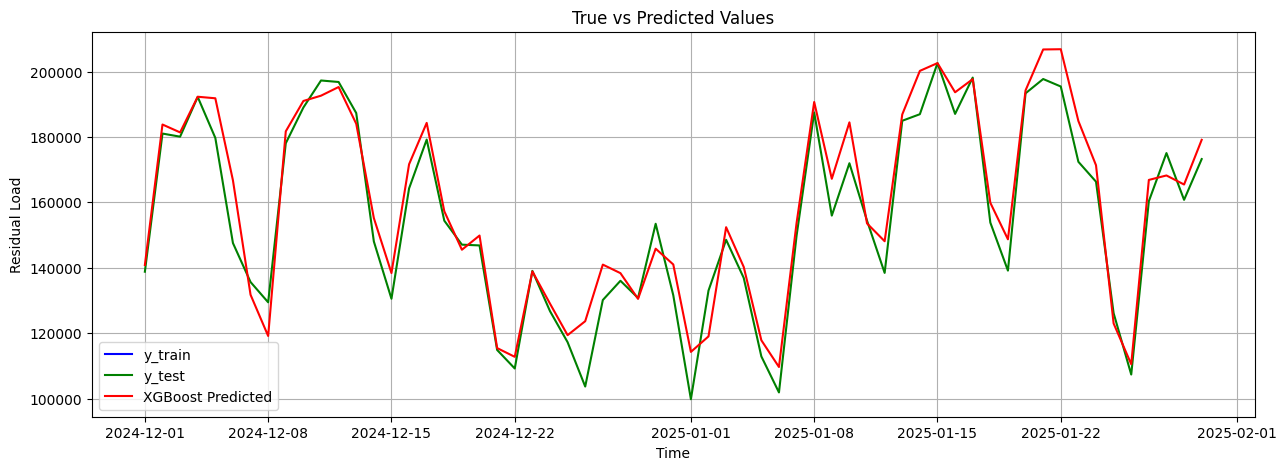

In [1049]:
start_date = '2024-12-01'
end_date = '2025-01-30'

y_train_df = pd.DataFrame(y_train).rename(columns={y_train.name: 'y_train'})
y_test_df = pd.DataFrame(y_test).rename(columns={y_test.name: 'y_test'})
xgb_pred_df = pd.DataFrame(xgb_pred, index=y_test.index).rename(columns={0: 'xgb_pred'})

# Merge them all into a single DataFrame
combined_df = pd.concat([y_train_df, y_test_df, xgb_pred_df], axis=1)
filtered_df = combined_df.loc[start_date:end_date]

# Plotting the combined DataFrame
plt.figure(figsize=(15, 5))

plt.plot(filtered_df.index, filtered_df['y_train'], label='y_train', color='blue')
plt.plot(filtered_df.index, filtered_df['y_test'], label='y_test', color='green')
plt.plot(filtered_df.index, filtered_df['xgb_pred'], label='XGBoost Predicted', color='red')


plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Residual Load')
plt.grid(True)
plt.legend()

plt.show()

### Feature Importance

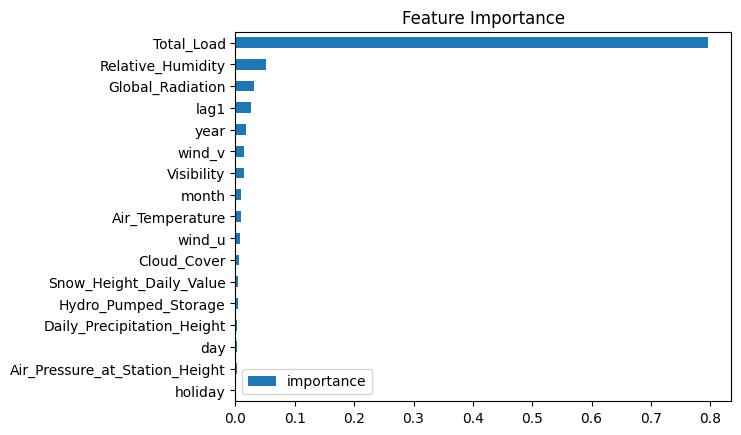

In [1050]:
fi = pd.DataFrame(data=xgb_model.feature_importances_, index=xgb_model.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### TODO
- Timeseries Cross Validation✔️
- Fine Tuning of XGBoost's Parameter and Hyperparameter 
  
  Relevant source: https://www.youtube.com/watch?v=1rZpbvSI26c


- Lag Feature Optimization ✔️
  
  Sources: https://www.youtube.com/watch?v=z3ZnOW-S550


- knn review when there's still time




# Notes
## 1. Reason to use xgboost
XGBoost
Pros:
Often performs well for many types of problems, including time series, because it handles both regression and classification tasks effectively.
Can handle missing data and outliers well.
Strong regularization helps avoid overfitting.
Cons:
XGBoost isn’t inherently designed for time series problems. It doesn’t have a built-in way to handle time dependencies unless you explicitly engineer features like lag variables or rolling windows.
Tuning XGBoost for time series can be tricky and requires expertise.

## 2. Why TimeSeriesSplit works better (Timeseries Cross Validation):
### Avoiding data leakage:

In traditional cross-validation, data from future periods may be used to predict past periods, which is unrealistic and would cause data leakage. TimeSeriesSplit ensures that the model only has access to past data to predict future outcomes (no peeking ahead). This is crucial for time series problems, where future values cannot inform past predictions.

### Training on more data:

With each fold in time series cross-validation, the training set is progressively larger because it includes all data up to the test set for that fold. This means that the model is exposed to a growing amount of data, which typically improves its ability to generalize, especially for time series models.
By the end of the cross-validation process, the model has been trained on almost all of the data and evaluated multiple times, which leads to a more stable and reliable performance estimate.
### Realistic performance estimation:

TimeSeriesSplit gives a more accurate estimation of how the model will perform in production, where the data always arrives sequentially. The performance is measured on data that is strictly "in the future" relative to the training set, simulating how the model would behave in real-world forecasting.